# Newick Parser: Python Port of jstree.js

This notebook implements a Python port of the Newick parser from [Taxonium's jstree.js](https://github.com/theosanderson/taxonium/blob/master/taxonium_component/src/utils/jstree.js), which is based on [Heng Li's jstree](https://github.com/lh3/jstreeview).

## Goals
1. Parse Newick format strings (e.g., from `tskit.Tree.newick()`)
2. Compute x,y coordinates using the same algorithm as jstree.js
3. Compare the resulting tree structure with our TreeGraph construction

## Key Differences from TreeGraph
- **Node ordering**: Newick uses "finishing order" (post-order traversal), we use node IDs
- **Coordinate system**: 
  - Newick: x = cumulative branch length (time), y = layout
  - TreeGraph: x = layout, y = normalized time
- **Time handling**: Newick uses branch lengths; tskit uses absolute node times

## Cell 1: Dependencies & Setup

In [15]:
import numpy as np
import tskit
from dataclasses import dataclass, field
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt

np.set_printoptions(threshold=20, edgeitems=5)

## Cell 2: Load Tree Sequence & Get Newick String

In [16]:
# Modify this path to your tree sequence file
TREE_FILE = "../../../UPLOADS/test/slimquant2.trees"

# Load the tree sequence
ts = tskit.load(TREE_FILE)

# Choose a tree index
tree_idx = 0
tskit_tree = ts.at_index(tree_idx)

# Get Newick string
roots = list(tskit_tree.roots)
print(f"Tree {tree_idx} has {len(roots)} root(s): {roots}")

if len(roots) == 1:
    newick_str = tskit_tree.newick()
else:
    # Concatenate newick strings for all roots (each ends with ';')
    newick_parts = [tskit_tree.newick(root=r) for r in roots]
    newick_str = "".join(newick_parts)
    print(f"Combined Newick from {len(roots)} roots")

print(f"\nNewick string (first 200 chars):")
print(newick_str[:200] + "..." if len(newick_str) > 200 else newick_str)
print(f"\nTotal length: {len(newick_str)} characters")

Tree 0 has 2 root(s): [0, 2]
Combined Newick from 2 roots

Newick string (first 200 chars):
(136:20000.00000000000000);(((((((107:44.00000000000000,118:44.00000000000000):48.00000000000000,(124:17.00000000000000,161:17.00000000000000):75.00000000000000):1240.00000000000000,150:1332.000000000...

Total length: 3375 characters


## Cell 3: Newick Node & Tree Data Structures

Based on jstree.js's node structure:
```javascript
{
    parent: null,      // pointer to parent node
    child: [],         // array of child nodes
    name: "",          // node name
    meta: "",          // metadata in brackets []
    d: -1.0,           // distance to parent (branch length)
    x: 0.0,            // computed x coordinate
    y: 0.0,            // computed y coordinate
}
```

In [17]:
@dataclass
class NewickNode:
    """A node in the Newick tree.
    
    Attributes:
        parent: Reference to parent node (None for root)
        children: List of child nodes
        name: Node name/label
        meta: Metadata string (content within [] brackets)
        d: Distance to parent (branch length), -1 if not specified
        x: Computed x coordinate (cumulative branch length from root)
        y: Computed y coordinate (layout position)
        miny: Minimum y among descendants (for internal nodes)
        maxy: Maximum y among descendants (for internal nodes)
    """
    parent: Optional['NewickNode'] = None
    children: List['NewickNode'] = field(default_factory=list)
    name: str = ""
    meta: str = ""
    d: float = -1.0
    x: float = 0.0
    y: float = 0.0
    miny: float = 0.0
    maxy: float = 0.0
    
    def is_tip(self) -> bool:
        """Check if this node is a leaf/tip."""
        return len(self.children) == 0
    
    def __repr__(self) -> str:
        return f"NewickNode(name='{self.name}', d={self.d:.4f}, x={self.x:.4f}, y={self.y:.4f}, children={len(self.children)})"


@dataclass
class NewickTree:
    """A parsed Newick tree.
    
    Attributes:
        nodes: List of nodes in finishing order (leftmost leaf first, root last)
        error: Parsing error flags (0=OK, 1=missing '(', 2=missing ')', 4=unpaired brackets)
        n_tips: Number of tips/leaves in the tree
        root: Reference to the last root node (backward compat)
        roots: List of all root nodes (for multi-root trees)
    """
    nodes: List[NewickNode] = field(default_factory=list)
    error: int = 0
    n_tips: int = 0
    root: Optional[NewickNode] = None
    roots: List[NewickNode] = field(default_factory=list)
    
    def __repr__(self) -> str:
        return f"NewickTree(nodes={len(self.nodes)}, n_tips={self.n_tips}, roots={len(self.roots)}, error={self.error})"

## Cell 4: Newick Parser (Python port of jstree.js `kn_parse`)

The parser processes the Newick string character by character:
- `(` - Push marker (-1) onto stack, begin subtree
- `)` - Pop to marker, create internal node linking children
- `,` - Separator between siblings (no action needed)
- `:value` - Branch length
- `[...]` - Metadata
- Other printable chars - Node name

In [18]:
def kn_add_node(s: str, l: int, tree: NewickTree) -> Tuple[int, NewickNode]:
    """
    Parse a node starting at position l in string s.
    
    Extracts:
    - name: characters before ':' or '['
    - d: distance after ':'
    - meta: content within '[' and ']'
    
    Returns:
        (new_position, node): Updated string position and the new node
    """
    node = NewickNode()
    beg = l
    end = 0
    
    i = l
    # Stop at ',', ')', or ';' (semicolon terminates the Newick string)
    while i < len(s) and s[i] != ',' and s[i] != ')' and s[i] != ';':
        c = s[i]
        
        if c == '[':
            # Metadata in brackets
            meta_beg = i
            if end == 0:
                end = i
            while i < len(s) and s[i] != ']':
                i += 1
            if i == len(s):
                tree.error |= 4  # Unpaired brackets
                break
            node.meta = s[meta_beg:i+1]
            i += 1
            
        elif c == ':':
            # Branch length
            if end == 0:
                end = i
            i += 1
            j = i
            while i < len(s):
                cc = s[i]
                if not (cc.isdigit() or cc in 'eE+-.') :
                    break
                i += 1
            if j < i:
                try:
                    node.d = float(s[j:i])
                except ValueError:
                    pass
            i -= 1
            i += 1
            
        elif c < '!' or c > '~':
            # Non-printable character marks end of name
            if end == 0:
                end = i
            i += 1
        else:
            i += 1
    
    if end == 0:
        end = i
    if end > beg:
        node.name = s[beg:end]
    
    tree.nodes.append(node)
    return i, node


def kn_parse(s: str) -> NewickTree:
    """
    Parse a Newick format string into a tree structure.
    
    This is a Python port of jstree.js's kn_parse function.
    Supports multi-root trees (concatenated Newick strings).
    
    Args:
        s: Newick format string (or multiple concatenated Newick strings)
    
    Returns:
        NewickTree with nodes in finishing order (leftmost leaf first, roots last)
    """
    stack = []  # Stack of node indices, -1 marks start of subtree
    tree = NewickTree()
    
    l = 0
    while l < len(s):
        # Skip whitespace
        while l < len(s) and (s[l] < '!' or s[l] > '~'):
            l += 1
        if l >= len(s):
            break
        
        c = s[l]
        
        if c == ',' or c == ';':
            # Sibling separator or end of string
            l += 1
            
        elif c == '(':
            # Start of subtree: push marker
            stack.append(-1)
            l += 1
            
        elif c == ')':
            # End of subtree: pop children and create internal node
            x = len(tree.nodes)  # Index where new internal node will be
            
            # Find the matching '(' marker
            marker_idx = -1
            for i in range(len(stack) - 1, -1, -1):
                if stack[i] < 0:
                    marker_idx = i
                    break
            
            if marker_idx < 0:
                tree.error |= 1  # Missing left parenthesis
                break
            
            # Number of children
            m = len(stack) - 1 - marker_idx
            
            # Parse the internal node (after the ')')
            l, node = kn_add_node(s, l + 1, tree)
            
            # Link children to this internal node
            for j in range(m):
                child_idx = stack[len(stack) - m + j]
                node.children.append(tree.nodes[child_idx])
                tree.nodes[child_idx].parent = node
            
            # Pop children and marker from stack, push new node
            stack = stack[:marker_idx]
            stack.append(x)
            
        else:
            # Tip node
            tree.n_tips += 1
            stack.append(len(tree.nodes))
            l, _ = kn_add_node(s, l, tree)
    
    # Only error if unmatched '(' marker remains (negative value)
    if any(s < 0 for s in stack):
        tree.error |= 2  # Missing right parenthesis
    
    # Collect all roots from stack (nodes with no parent)
    tree.roots = [tree.nodes[idx] for idx in stack if idx >= 0]
    if tree.roots:
        tree.root = tree.roots[-1]  # Last root for backward compat
    
    return tree


# Test with a simple example
test_newick = "((A:0.1,B:0.2):0.3,C:0.4);"
test_tree = kn_parse(test_newick)

print(f"Test Newick: {test_newick}")
print(f"Parsed tree: {test_tree}")
print(f"")
print("Nodes (in finishing order):")
for i, node in enumerate(test_tree.nodes):
    parent_name = node.parent.name if node.parent else "None"
    children_names = [c.name for c in node.children]
    print(f"  [{i}] name='{node.name}', d={node.d}, parent='{parent_name}', children={children_names}")

# Test with multi-root (concatenated Newick strings)
print(f"\n--- Multi-root test ---")
multi_newick = "(A:0.1,B:0.2);(C:0.3,D:0.4);"
multi_tree = kn_parse(multi_newick)
print(f"Multi-root Newick: {multi_newick}")
print(f"Parsed tree: {multi_tree}")
print(f"Roots: {[r.name or '(internal)' for r in multi_tree.roots]}")

Test Newick: ((A:0.1,B:0.2):0.3,C:0.4);
Parsed tree: NewickTree(nodes=5, n_tips=3, roots=1, error=0)

Nodes (in finishing order):
  [0] name='A', d=0.1, parent='', children=[]
  [1] name='B', d=0.2, parent='', children=[]
  [2] name='', d=0.3, parent='', children=['A', 'B']
  [3] name='C', d=0.4, parent='', children=[]
  [4] name='', d=-1.0, parent='None', children=['', 'C']

--- Multi-root test ---
Multi-root Newick: (A:0.1,B:0.2);(C:0.3,D:0.4);
Parsed tree: NewickTree(nodes=6, n_tips=4, roots=2, error=0)
Roots: ['(internal)', '(internal)']


## Cell 5: Coordinate Calculator (Python port of jstree.js `kn_calxy`)

The algorithm computes x and y coordinates:

### Y Coordinate (Layout Position)
- Tips get sequential values: 0, 1/(n-1), 2/(n-1), ..., 1
- Internal nodes get the average of their first and last child's y values
- This places parents centered between their children

### X Coordinate (Time/Branch Length)
- If `is_real=True`: Use cumulative branch lengths from root
  - Root starts at x = root.d (or 0 if negative)
  - Each node: x = parent.x + node.d
- If `is_real=False`: Uniform spacing (all branches = 1.0)
  - Tips are moved to the maximum depth
- Final step: Normalize all x values to [0, 1]

In [19]:
def kn_calxy(tree: NewickTree, is_real: bool = True) -> bool:
    """
    Calculate x,y coordinates for each node in the tree.
    
    This is a Python port of jstree.js's kn_calxy function.
    Supports multi-root trees.
    
    Args:
        tree: NewickTree with nodes in finishing order
        is_real: If True, use actual branch lengths for x; otherwise uniform spacing
    
    Returns:
        bool: Whether real branch lengths were used (may be False if all are missing)
    """
    if not tree.nodes:
        return is_real
    
    # Calculate Y coordinates (layout position)
    # Tips get sequential values, internal nodes get average of children
    scale = tree.n_tips - 1 if tree.n_tips > 1 else 1
    tip_counter = 0
    
    for node in tree.nodes:
        if node.children:  # Internal node
            # Average of first and last child's y
            node.y = (node.children[0].y + node.children[-1].y) / 2.0
            node.miny = node.children[0].miny
            node.maxy = node.children[-1].maxy
        else:  # Tip
            node.y = tip_counter / scale
            node.miny = node.maxy = node.y
            tip_counter += 1
    
    # Get all roots (use roots list if available, otherwise fall back to last node)
    roots = tree.roots if tree.roots else [tree.nodes[-1]]
    
    # Calculate X coordinates
    if is_real:
        # Use actual branch lengths (cumulative from root)
        # First pass: set root x values and find initial scale
        scale = 0.0
        for root in roots:
            root.x = root.d if root.d >= 0.0 else 0.0
            if root.x > scale:
                scale = root.x
        
        # Traverse from roots to tips (reverse order since nodes are in finishing order)
        for i in range(len(tree.nodes) - 1, -1, -1):
            node = tree.nodes[i]
            if node.parent is not None:
                node.x = node.parent.x + (node.d if node.d >= 0.0 else 0.0)
                if node.x > scale:
                    scale = node.x
        
        if scale == 0.0:
            is_real = False
    
    if not is_real:
        # Uniform spacing (no branch lengths)
        for root in roots:
            root.x = 1.0
        scale = 1.0
        
        for i in range(len(tree.nodes) - 1, -1, -1):
            node = tree.nodes[i]
            if node.parent is not None:
                node.x = node.parent.x + 1.0
                if node.x > scale:
                    scale = node.x
        
        # Move tips to maximum depth
        for node in tree.nodes:
            if not node.children and node not in roots:
                node.x = scale
    
    # Normalize x to [0, 1]
    if scale > 0:
        for node in tree.nodes:
            node.x /= scale
    
    return is_real


# Test with our simple example
kn_calxy(test_tree, is_real=True)

print(f"After kn_calxy (is_real=True):")
print(f"{'Node':>10} {'x':>8} {'y':>8} {'d':>8} {'Type':>10}")
print("-" * 50)
for node in test_tree.nodes:
    node_type = "TIP" if node.is_tip() else "INTERNAL"
    if node.parent is None:
        node_type = "ROOT"
    name = node.name if node.name else "(internal)"
    print(f"{name:>10} {node.x:>8.4f} {node.y:>8.4f} {node.d:>8.4f} {node_type:>10}")

# Test multi-root tree coordinates
print(f"\n--- Multi-root coordinates ---")
kn_calxy(multi_tree, is_real=True)
print(f"{'Node':>10} {'x':>8} {'y':>8} {'d':>8} {'Type':>10}")
print("-" * 50)
for node in multi_tree.nodes:
    node_type = "TIP" if node.is_tip() else "INTERNAL"
    if node in multi_tree.roots:
        node_type = "ROOT"
    name = node.name if node.name else "(internal)"
    print(f"{name:>10} {node.x:>8.4f} {node.y:>8.4f} {node.d:>8.4f} {node_type:>10}")

After kn_calxy (is_real=True):
      Node        x        y        d       Type
--------------------------------------------------
         A   0.8000   0.0000   0.1000        TIP
         B   1.0000   0.5000   0.2000        TIP
(internal)   0.6000   0.2500   0.3000   INTERNAL
         C   0.8000   1.0000   0.4000        TIP
(internal)   0.0000   0.6250  -1.0000       ROOT

--- Multi-root coordinates ---
      Node        x        y        d       Type
--------------------------------------------------
         A   0.2500   0.0000   0.1000        TIP
         B   0.5000   0.3333   0.2000        TIP
(internal)   0.0000   0.1667  -1.0000       ROOT
         C   0.7500   0.6667   0.3000        TIP
         D   1.0000   1.0000   0.4000        TIP


RecursionError: maximum recursion depth exceeded

## Cell 6: Parse tskit's Newick Output

In [ ]:
# Parse the Newick string from tskit
nwk_tree = kn_parse(newick_str)

print(f"Parsed Newick tree:")
print(f"  Nodes: {len(nwk_tree.nodes)}")
print(f"  Tips: {nwk_tree.n_tips}")
print(f"  Error: {nwk_tree.error} (0 = OK)")
print(f"")

# Calculate coordinates
used_real = kn_calxy(nwk_tree, is_real=True)
print(f"Coordinates calculated (used_real={used_real}):")

# Show first 10 and last 5 nodes
print(f"")
print(f"First 10 nodes (in finishing order):")
print(f"{'Idx':>4} {'Name':>10} {'x':>8} {'y':>8} {'d':>10} {'Type':>10}")
print("-" * 56)
for i, node in enumerate(nwk_tree.nodes[:10]):
    node_type = "TIP" if node.is_tip() else "INTERNAL"
    name = node.name[:10] if node.name else ""
    print(f"{i:>4} {name:>10} {node.x:>8.4f} {node.y:>8.4f} {node.d:>10.4f} {node_type:>10}")

print(f"...")
print(f"Last 5 nodes:")
for i, node in enumerate(nwk_tree.nodes[-5:]):
    idx = len(nwk_tree.nodes) - 5 + i
    node_type = "TIP" if node.is_tip() else "INTERNAL"
    if node.parent is None:
        node_type = "ROOT"
    name = node.name[:10] if node.name else ""
    print(f"{idx:>4} {name:>10} {node.x:>8.4f} {node.y:>8.4f} {node.d:>10.4f} {node_type:>10}")

Parsed Newick tree:
  Nodes: 158
  Tips: 79
  Error: 0 (0 = OK)

Coordinates calculated (used_real=True):

First 10 nodes (in finishing order):
 Idx       Name        x        y          d       Type
--------------------------------------------------------
   0        107   1.0000   0.0000    44.0000        TIP
   1        118   1.0000   0.0128    44.0000        TIP
   2              0.9978   0.0064    48.0000   INTERNAL
   3        124   1.0000   0.0256    17.0000        TIP
   4        161   1.0000   0.0385    17.0000        TIP
   5              0.9991   0.0321    75.0000   INTERNAL
   6              0.9954   0.0192  1240.0000   INTERNAL
   7        150   1.0000   0.0513  1332.0000        TIP
   8              0.9334   0.0353   100.0000   INTERNAL
   9        102   1.0000   0.0641    10.0000        TIP
...
Last 5 nodes:
 153              0.9702   0.9535    48.0000   INTERNAL
 154        141   1.0000   1.0000   644.0000        TIP
 155              0.9678   0.9768  2113.0000   INTERN

## Cell 7: Visualize Newick Tree

Plot the Newick tree using its computed coordinates.

In [ ]:
def plot_newick_tree(tree: NewickTree, ax=None, title="Newick Tree"):
    """Plot a Newick tree using its computed x,y coordinates."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Collect coordinates and colors
    x_coords = []
    y_coords = []
    colors = []
    
    for node in tree.nodes:
        x_coords.append(node.x)
        y_coords.append(node.y)
        
        if node in tree.roots:  # Check against roots list
            colors.append('red')  # Root
        elif node.is_tip():
            colors.append('green')  # Tip
        else:
            colors.append('blue')  # Internal
    
    # Draw edges (elbow connectors)
    for node in tree.nodes:
        if node.parent is not None:
            p = node.parent
            # Horizontal line from node to parent's x
            ax.plot([node.x, p.x], [node.y, node.y], 'k-', alpha=0.4, linewidth=0.8)
            # Vertical line at parent's x
            ax.plot([p.x, p.x], [node.y, p.y], 'k-', alpha=0.4, linewidth=0.8)
    
    # Draw nodes
    ax.scatter(x_coords, y_coords, c=colors, s=30, zorder=5)
    
    ax.set_xlabel('X (cumulative branch length, normalized)')
    ax.set_ylabel('Y (layout position)')
    ax.set_title(f"{title}\n({len(tree.nodes)} nodes, {tree.n_tips} tips, {len(tree.roots)} roots)")
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label='Root'),
        Patch(facecolor='blue', label='Internal'),
        Patch(facecolor='green', label='Tip')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    
    return ax


# Plot the Newick tree
fig, ax = plt.subplots(figsize=(10, 8))
plot_newick_tree(nwk_tree, ax, title=f"Newick Tree (Tree {tree_idx})")
plt.tight_layout()
plt.show()

## Cell 8: Build TreeGraph for Comparison

Now let's build our TreeGraph using the algorithm from `tree_algorithm_explained.ipynb` and compare.

In [20]:
from numba import njit

@njit(cache=True)
def _compute_x_postorder(children_indptr, children_data, roots, num_nodes):
    """Numba-compiled post-order traversal for computing x coordinates."""
    x = np.full(num_nodes, -1.0, dtype=np.float32)
    tip_counter = 0
    
    stack_nodes = np.empty(num_nodes, dtype=np.int32)
    stack_visited = np.empty(num_nodes, dtype=np.uint8)
    
    for i in range(len(roots)):
        root = roots[i]
        stack_ptr = 0
        
        stack_nodes[stack_ptr] = root
        stack_visited[stack_ptr] = 0
        stack_ptr += 1
        
        while stack_ptr > 0:
            stack_ptr -= 1
            node = stack_nodes[stack_ptr]
            visited = stack_visited[stack_ptr]
            
            start = children_indptr[node]
            end = children_indptr[node + 1]
            num_children = end - start
            
            if visited == 0 and num_children > 0:
                stack_nodes[stack_ptr] = node
                stack_visited[stack_ptr] = 1
                stack_ptr += 1
                
                for j in range(start, end):
                    stack_nodes[stack_ptr] = children_data[j]
                    stack_visited[stack_ptr] = 0
                    stack_ptr += 1
            else:
                if num_children == 0:
                    x[node] = tip_counter
                    tip_counter += 1
                else:
                    total = 0.0
                    for j in range(start, end):
                        total += x[children_data[j]]
                    x[node] = total / num_children
    
    return x, tip_counter


@dataclass
class TreeGraph:
    """Graph representation using numpy arrays with CSR format for children."""
    parent: np.ndarray
    time: np.ndarray
    children_indptr: np.ndarray
    children_data: np.ndarray
    x: np.ndarray
    y: np.ndarray
    in_tree: np.ndarray
    
    def children(self, node_id: int) -> np.ndarray:
        return self.children_data[self.children_indptr[node_id]:self.children_indptr[node_id + 1]]
    
    def is_tip(self, node_id: int) -> bool:
        return self.children_indptr[node_id + 1] == self.children_indptr[node_id]


def construct_tree(ts, tree_idx: int, root_node: Optional[int] = None) -> TreeGraph:
    """Construct TreeGraph for a specific tree (optionally limited to one root's subtree)."""
    edges = ts.tables.edges
    nodes = ts.tables.nodes
    breakpoints = list(ts.breakpoints())
    
    interval_left = breakpoints[tree_idx]
    num_nodes = len(nodes.time)
    node_times = nodes.time
    min_time = ts.min_time
    max_time = ts.max_time
    
    # Edge filtering & parent array
    active_mask = (edges.left <= interval_left) & (edges.right > interval_left)
    active_parents = edges.parent[active_mask]
    active_children = edges.child[active_mask]
    
    parent = np.full(num_nodes, -1, dtype=np.int32)
    parent[active_children] = active_parents
    
    # CSR children structure
    child_counts = np.bincount(active_parents, minlength=num_nodes).astype(np.int32)
    children_indptr = np.zeros(num_nodes + 1, dtype=np.int32)
    children_indptr[1:] = np.cumsum(child_counts)
    sort_idx = np.argsort(active_parents, kind='stable')
    children_data = active_children[sort_idx].astype(np.int32)
    
    # Track which nodes are in this tree
    in_tree = np.zeros(num_nodes, dtype=np.bool_)
    in_tree[active_children] = True
    in_tree[active_parents] = True
    
    # If root_node specified, limit to that subtree
    if root_node is not None:
        # Mark only nodes in subtree
        subtree_mask = np.zeros(num_nodes, dtype=np.bool_)
        stack = [root_node]
        while stack:
            n = stack.pop()
            subtree_mask[n] = True
            start = children_indptr[n]
            end = children_indptr[n + 1]
            for j in range(start, end):
                stack.append(children_data[j])
        in_tree = in_tree & subtree_mask
    
    # Y coordinate: normalized time
    time_range = max_time - min_time if max_time > min_time else 1.0
    y = ((max_time - node_times) / time_range).astype(np.float32)
    
    # X coordinate: post-order traversal
    if root_node is not None:
        roots = np.array([root_node], dtype=np.int32)
    else:
        roots = np.where(in_tree & (parent == -1))[0].astype(np.int32)
    
    x, tip_counter = _compute_x_postorder(children_indptr, children_data, roots, num_nodes)
    
    # Normalize x to [0, 1]
    if tip_counter > 1:
        x[in_tree] /= (tip_counter - 1)
    
    return TreeGraph(
        parent=parent,
        time=node_times.astype(np.float32),
        children_indptr=children_indptr,
        children_data=children_data,
        x=x,
        y=y,
        in_tree=in_tree
    )


# Build TreeGraph for comparison (use all roots)
graph = construct_tree(ts, tree_idx)

print(f"TreeGraph constructed:")
print(f"  Nodes in tree: {np.sum(graph.in_tree)}")
print(f"  Tips: {sum(1 for n in np.where(graph.in_tree)[0] if graph.is_tip(n))}")
print(f"  X range: [{graph.x[graph.in_tree].min():.4f}, {graph.x[graph.in_tree].max():.4f}]")
print(f"  Y range: [{graph.y[graph.in_tree].min():.4f}, {graph.y[graph.in_tree].max():.4f}]")

TreeGraph constructed:
  Nodes in tree: 160
  Tips: 80
  X range: [0.0000, 1.0000]
  Y range: [0.0000, 1.0000]


## Cell 9: Side-by-Side Comparison

Compare the Newick tree (parsed from string) with our TreeGraph (computed directly from tskit tables).

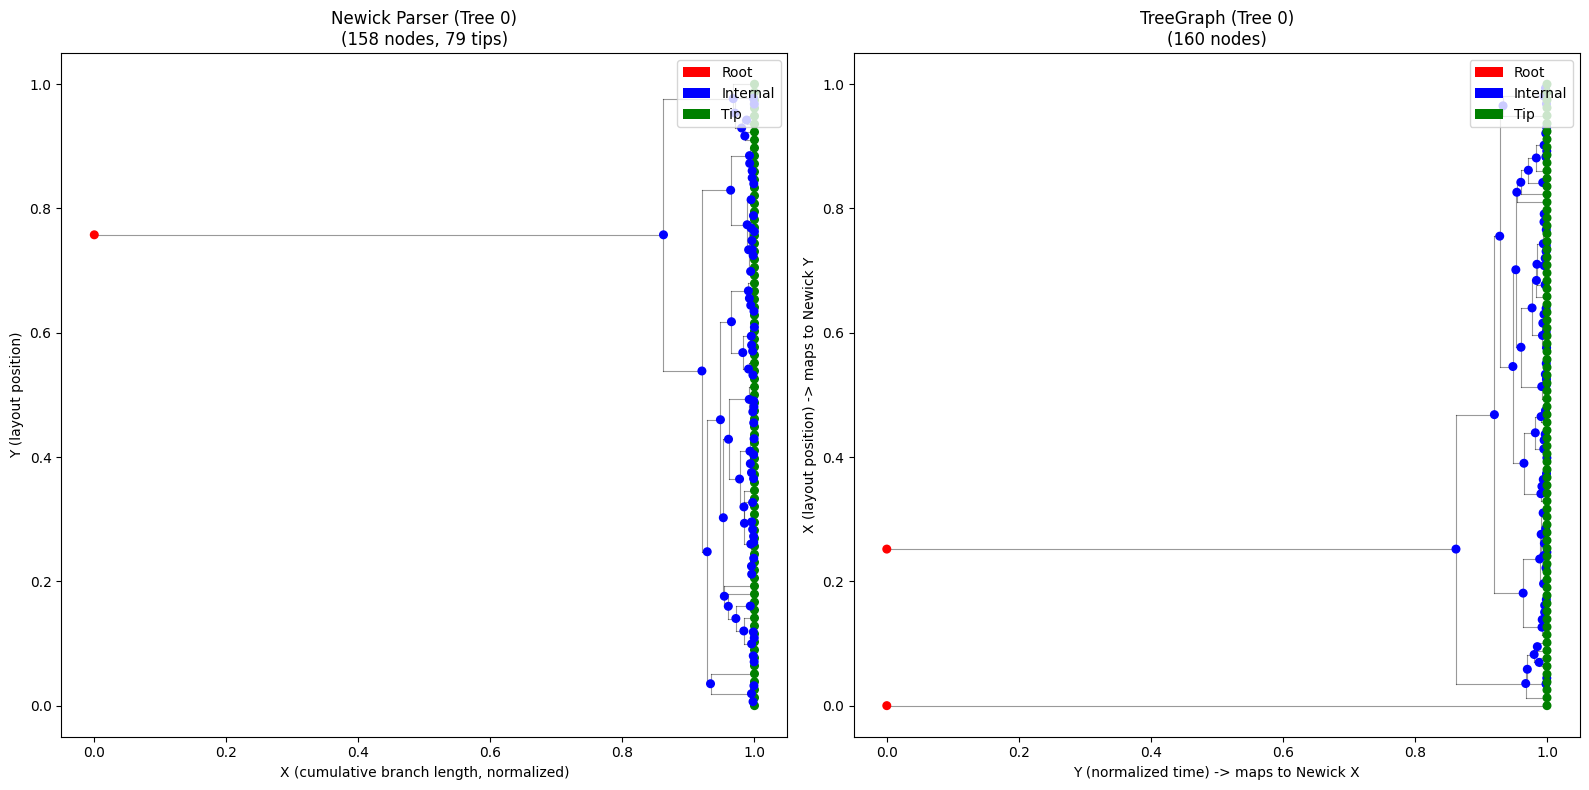

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot Newick tree
plot_newick_tree(nwk_tree, axes[0], title=f"Newick Parser (Tree {tree_idx})")

# Plot TreeGraph
indices = np.where(graph.in_tree)[0]
colors = []
for i in indices:
    if graph.parent[i] == -1:
        colors.append('red')
    elif graph.is_tip(i):
        colors.append('green')
    else:
        colors.append('blue')

# Draw edges
for node in indices:
    if graph.parent[node] != -1:
        p = graph.parent[node]
        # Note: TreeGraph uses y=time, x=layout; we swap for comparison
        # TreeGraph: x=layout, y=time; Newick: x=time, y=layout
        axes[1].plot([graph.y[node], graph.y[p]], [graph.x[node], graph.x[node]], 
                     'k-', alpha=0.4, linewidth=0.8)
        axes[1].plot([graph.y[p], graph.y[p]], [graph.x[node], graph.x[p]], 
                     'k-', alpha=0.4, linewidth=0.8)

# Draw nodes (swap x,y to match Newick convention for comparison)
axes[1].scatter(graph.y[indices], graph.x[indices], c=colors, s=30, zorder=5)

axes[1].set_xlabel('Y (normalized time) -> maps to Newick X')
axes[1].set_ylabel('X (layout position) -> maps to Newick Y')
axes[1].set_title(f"TreeGraph (Tree {tree_idx})\n({np.sum(graph.in_tree)} nodes)")

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='Root'),
    Patch(facecolor='blue', label='Internal'),
    Patch(facecolor='green', label='Tip')
]
axes[1].legend(handles=legend_elements, loc='upper right')
axes[1].set_xlim(-0.05, 1.05)
axes[1].set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

## Cell 10: Structural Comparison

Compare the tree structure between Newick and TreeGraph representations.

In [23]:
print("=== Structural Comparison ===")
print(f"")

# Root counts
print(f"Root counts:")
print(f"  tskit roots: {len(roots)}")
print(f"  Newick roots: {len(nwk_tree.roots)}")
print(f"  Match: {len(roots) == len(nwk_tree.roots)}")
print(f"")

# Node counts
print(f"Node counts:")
print(f"  Newick nodes: {len(nwk_tree.nodes)}")
print(f"  TreeGraph in_tree: {np.sum(graph.in_tree)}")
print(f"")

# Tip counts
print(f"Tip counts:")
print(f"  Newick n_tips: {nwk_tree.n_tips}")
treegraph_tips = sum(1 for n in np.where(graph.in_tree)[0] if graph.is_tip(n))
print(f"  TreeGraph tips: {treegraph_tips}")
print(f"  Match: {nwk_tree.n_tips == treegraph_tips}")
print(f"")

# Error status
print(f"Parsing status:")
print(f"  Newick error: {nwk_tree.error} (0 = OK)")
print(f"")

# Coordinate ranges
print(f"Coordinate ranges:")
nwk_x = [n.x for n in nwk_tree.nodes]
nwk_y = [n.y for n in nwk_tree.nodes]
print(f"  Newick X: [{min(nwk_x):.4f}, {max(nwk_x):.4f}]")
print(f"  Newick Y: [{min(nwk_y):.4f}, {max(nwk_y):.4f}]")
print(f"  TreeGraph X (layout): [{graph.x[graph.in_tree].min():.4f}, {graph.x[graph.in_tree].max():.4f}]")
print(f"  TreeGraph Y (time): [{graph.y[graph.in_tree].min():.4f}, {graph.y[graph.in_tree].max():.4f}]")
print(f"")

# Key differences
print(f"Key Differences:")
print(f"  1. Newick X = cumulative branch length (time); TreeGraph Y = normalized time")
print(f"  2. Newick Y = layout position; TreeGraph X = layout position")
print(f"  3. Newick uses branch lengths (d); TreeGraph uses absolute times")
print(f"  4. Newick internal Y = avg(first, last child); TreeGraph X = avg(all children)")

=== Structural Comparison ===

Root counts:
  tskit roots: 2


AttributeError: 'NewickTree' object has no attribute 'roots'

## Cell 11: Extract Node Names from Newick

The Newick format encodes node IDs in the names. Let's extract them.

In [24]:
# tskit encodes node IDs as names in Newick
# Let's create a mapping from Newick nodes to tskit node IDs

newick_to_tskit = {}
for i, node in enumerate(nwk_tree.nodes):
    if node.name:
        try:
            tskit_id = int(node.name)
            newick_to_tskit[i] = tskit_id
        except ValueError:
            pass

print(f"Mapped {len(newick_to_tskit)} Newick nodes to tskit IDs")
print(f"")

# Show first 10 mappings
print(f"First 10 mappings (Newick idx -> tskit ID):")
for i, (nwk_idx, tskit_id) in enumerate(list(newick_to_tskit.items())[:10]):
    node = nwk_tree.nodes[nwk_idx]
    print(f"  Newick[{nwk_idx}] -> tskit[{tskit_id}]: x={node.x:.4f}, y={node.y:.4f}")

Mapped 79 Newick nodes to tskit IDs

First 10 mappings (Newick idx -> tskit ID):
  Newick[0] -> tskit[107]: x=1.0000, y=0.0000
  Newick[1] -> tskit[118]: x=1.0000, y=0.0128
  Newick[3] -> tskit[124]: x=1.0000, y=0.0256
  Newick[4] -> tskit[161]: x=1.0000, y=0.0385
  Newick[7] -> tskit[150]: x=1.0000, y=0.0513
  Newick[9] -> tskit[102]: x=1.0000, y=0.0641
  Newick[10] -> tskit[128]: x=1.0000, y=0.0769
  Newick[12] -> tskit[106]: x=1.0000, y=0.0897
  Newick[14] -> tskit[117]: x=1.0000, y=0.1026
  Newick[15] -> tskit[139]: x=1.0000, y=0.1154


## Summary

This notebook demonstrated:

### 1. Newick Parser (`kn_parse`)
- Stack-based parser that processes characters sequentially
- Builds nodes in "finishing order" (leftmost leaf first, root last)
- Extracts node names, branch lengths, and metadata

### 2. Coordinate Calculator (`kn_calxy`)
- **Y coordinate**: Tips get sequential values 0 to 1; internal nodes get average of first/last child
- **X coordinate**: Cumulative branch lengths from root, normalized to [0, 1]

### 3. Comparison with TreeGraph
| Aspect | Newick (jstree.js) | TreeGraph (Lorax) |
|--------|-------------------|-------------------|
| Node ordering | Finishing order (post-order) | Node IDs |
| X axis | Cumulative branch length | Layout position |
| Y axis | Layout position | Normalized time |
| Internal node position | Avg of first & last child | Avg of all children |
| Time representation | Branch lengths (relative) | Absolute times |

### Use Cases
- **Newick parser**: Useful for importing trees from external formats
- **TreeGraph**: Optimized for tskit-based workflows with direct table access